tb - 7/18/2022 - Using PySR to symbolically regress one-dimensional CDFs

# Imports

In [119]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import scipy
import xarray as xr
import matplotlib as mpl

from scipy.integrate import cumtrapz,trapz
from scipy.special import erfc
from scipy.special import gamma
from scipy.special import erf
import sympy
from sympy.utilities.lambdify import lambdify, implemented_function

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import PolynomialFeatures

import pysr
from pysr import PySRRegressor

In [7]:
fz = 12
lw = 2
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

In [8]:
#pysr.install()

# Load CDFs for Aquaplanet Case

## Experiments

### Utilities

In [203]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
save_name = path_data+'2022_07_18_PDF_CDF_TRAIN_BOTH_M4K_P4K'

In [204]:
def edg2bin(edges):
    return (edges[:-1]+edges[1:])/2

In [205]:
def pdf2cdf(bins,pdf):
    return cumtrapz(x=bins,y=pdf,initial=0)

In [206]:
def cdf2pdf(bins,cdf):
    tmp = np.diff(cdf)/np.diff(bins)
    return edg2bin(np.concatenate(([0],tmp,[0])))

In [207]:
BIN = {}

In [208]:
tmp = pkl.load(open(save_name,'rb'))
PDF = tmp['PDF']
EDG = tmp['EDG']
for k in EDG.keys():
    BIN[k] = edg2bin(EDG[k])
    db = np.array(np.diff(EDG[k]), float)  
    CDF[k] = db*PDF[k].cumsum()

### Test

In [10]:
# Adding a few more functions
model = PySRRegressor(
    niterations=10,
    binary_operators=["+","*","/"],
    unary_operators=[
        "cos","exp","sin",
        'square','cube','abs','log10_abs','tan','sinh','cosh','tanh',
        'atan','asinh','acosh_abs','erf','erfc','gamma',
        'relu',
    ],
    model_selection="best",
    loss="loss(x, y) = (x - y)^2",  # Custom loss function (julia syntax)
)

In [ ]:
model.fit(BIN['T'].reshape(-1,1),CDF['T'].reshape(-1,1))

In [ ]:
def f2(x):
    return np.exp(np.tan(log10_abs(x))) 

In [ ]:
def f3(x):
    return np.exp(np.sin(np.sinh(log10_abs(x))))

In [ ]:
def f4(x):
    return np.cos(np.square(log10_abs(x) - 0.07344723))

In [ ]:
def f5(x):
    return np.square(np.cos(acosh_abs(cube(x * 0.006900512))))

In [ ]:
def f6(x):
    return np.cos(np.sinh(log10_abs(x)))

In [ ]:
def f7(x):
    return erfc(np.square(np.tan(np.arcsinh(gamma(np.arcsinh(x)))))) 

In [ ]:
model

In [ ]:
y = f2(BIN['T']); plt.plot(BIN['T'],y,label=str(mse(CDF['T'],y)));
y = f3(BIN['T']); plt.plot(BIN['T'],y,label=str(mse(CDF['T'],y)));
y = f4(BIN['T']); plt.plot(BIN['T'],y,label=str(mse(CDF['T'],y)));
y = f5(BIN['T']); plt.plot(BIN['T'],y,label=str(mse(CDF['T'],y)));
y = f6(BIN['T']); plt.plot(BIN['T'],y,label=str(mse(CDF['T'],y)));
y = f7(BIN['T']); plt.plot(BIN['T'],y,label=str(mse(CDF['T'],y)));
plt.plot(BIN['T'],CDF['T'],color='k')
plt.legend()

In [ ]:
plt.plot(BIN['T'],cdf2pdf(BIN['T'],f2(BIN['T'])))
plt.plot(BIN['T'],cdf2pdf(BIN['T'],f3(BIN['T'])))
plt.plot(BIN['T'],cdf2pdf(BIN['T'],f4(BIN['T'])))
plt.plot(BIN['T'],cdf2pdf(BIN['T'],f5(BIN['T'])))
plt.plot(BIN['T'],cdf2pdf(BIN['T'],f6(BIN['T'])))
plt.plot(BIN['T'],cdf2pdf(BIN['T'],f7(BIN['T'])))
plt.plot(BIN['T'],PDF['T'],color='k')

In [ ]:
model.fit(BIN['T'].reshape(-1,1),PDF['T'].reshape(-1,1))

In [ ]:
def cube(x):
    return x**3

In [ ]:
def g1(x):
    return np.square(np.tan(cube(np.cos(acosh_abs(x))))) / x

In [ ]:
def g2(x):
    return np.square(np.tan(np.cos(-acosh_abs(x)/0.49611235))) / x

In [ ]:
def g3(x):
    return np.square(np.tan(np.cos(cube(np.sin(acosh_abs(x)) / (-0.36724827))))) / x

In [ ]:
plt.plot(BIN['T'],PDF['T'])
y = plt.plot(BIN['T'],g1(BIN['T']))
plt.plot(BIN['T'],g2(BIN['T']))
plt.plot(BIN['T'],g3(BIN['T']))

In [ ]:
y = pdf2cdf(BIN['T'],g1(BIN['T'])); plt.plot(BIN['T'],y,label=str(mae(CDF['T'],y)));
y = pdf2cdf(BIN['T'],g2(BIN['T'])); plt.plot(BIN['T'],y,label=str(mae(CDF['T'],y)));
y = pdf2cdf(BIN['T'],g3(BIN['T'])); plt.plot(BIN['T'],y,label=str(mae(CDF['T'],y)));
plt.plot(BIN['T'],CDF['T'],color='k')
plt.legend()

## Loop over all keys

In [209]:
SYMB = {}

In [210]:
#Niter = 1000
Nratiomax = 10

### Testing complexity of constants

In [211]:
#for k in ['q','T','p','S0','SHF','LHF','LHFns','RH','B']:
k = 'q'
for ratio in np.arange(2,Nratiomax):
    print(ratio)
    SYMB[ratio] = PySRRegressor(
        complexity_of_constants=1,
        complexity_of_operators={
            "+":1,"*":1,"/":1,
            "cos":ratio,"exp":ratio,"sin":ratio,
            'square':ratio,'cube':ratio,'abs':ratio,
            'log10_abs':ratio,'tan':ratio,'sinh':ratio,
            'cosh':ratio,'tanh':ratio,
            'atan':ratio,'asinh':ratio,'acosh_abs':ratio,
            'erf':ratio,'erfc':ratio,'gamma':ratio,
            'relu':ratio
        },
        progress=True,
#         niterations=Niter,
        binary_operators=["+","*","/"],
        unary_operators=[
            "cos","exp","sin",
            'square','cube','abs','log10_abs','tan','sinh','cosh','tanh',
            'atan','asinh','acosh_abs','erf','erfc','gamma',
            'relu',
        ],
        model_selection="best",
        timeout_in_seconds=60 * 60,
        precision=32,
        loss="loss(x, y) = (x - y)^2",  # Custom loss function (julia syntax)
    )
    SYMB[ratio].fit(BIN[k].reshape(-1,1),CDF[k].reshape(-1,1))

2


/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/pysr/lib/python3.10/site-packages/pysr/sr.py:1068: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 3.080e+04
Head worker occupation: 94.2%
Progress: 86 / 600 total iterations (14.333%)
Hall of Fame:
-----------------------------------------
Complexity  loss       Score     Equation
1           7.633e-03  3.659e-07  0.94570136
5           5.247e-03  9.372e-02  cube(x0 + 0.97339743)
7           2.927e-03  2.918e-01  (((x0 + x0) / 0.23999786) + 0.8269614)
9           1.097e-03  4.906e-01  sin(cube((x0 + 2.3768024) + x0))
11          9.736e-04  5.978e-02  (sin(cube((x0 + 2.3768024) + x0)) + x0)
13          7.457e-04  1.333e-01  erf(cube(asinh(square(exp(acosh_abs(x0))))))
15          2.227e-04  6.042e-01  square(square(erf(square(square(exp(acosh_abs(x0)))))))
17          5.583e-05  6.918e-01  square(square(erf(square(square(exp(acosh_abs(x0 / 0.8577098)))))))
19          5.145e-05  4.089e-02  square(erf(square(asinh(square(square(exp(acosh_abs(x0 * -0.8272488))))))))

Press 'q' and then <enter> to stop execution early.

Cycles per second: 3.260e+04
Head wor

/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/pysr/lib/python3.10/site-packages/pysr/sr.py:1068: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 3.320e+04
Head worker occupation: 94.2%
Progress: 92 / 600 total iterations (15.333%)
Hall of Fame:
-----------------------------------------
Complexity  loss       Score     Equation
1           7.633e-03  3.049e-07  0.9456991
3           6.573e-03  7.482e-02  (x0 + 0.9314509)
5           5.782e-03  6.411e-02  ((x0 + x0) + 0.90559924)
6           2.033e-03  1.045e+00  (acosh_abs(x0) + 0.78677005)
8           1.678e-03  9.607e-02  (acosh_abs(x0 / -0.69021046) + 0.75827557)
9           1.487e-03  1.209e-01  (acosh_abs(acosh_abs(x0)) + 0.4007708)
11          8.322e-04  2.902e-01  (acosh_abs(x0 / acosh_abs(x0)) + 0.5572664)
14          8.172e-04  6.069e-03  (acosh_abs(x0 / tan(acosh_abs(x0))) + 0.5575192)
17          8.134e-04  1.532e-03  (acosh_abs(x0 / tan(tan(acosh_abs(x0)))) + 0.5575192)
18          5.337e-04  4.214e-01  (erf(asinh(acosh_abs(tan(acosh_abs(x0))))) + 0.41087115)

Press 'q' and then <enter> to stop execution early.

Cycles per second: 3.300e+

/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/pysr/lib/python3.10/site-packages/pysr/sr.py:1068: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 2.880e+04
Head worker occupation: 95.1%
Progress: 84 / 600 total iterations (14.000%)
Hall of Fame:
-----------------------------------------
Complexity  loss       Score     Equation
1           7.633e-03  3.049e-07  0.9457079
3           6.573e-03  7.482e-02  (x0 + 0.9314517)
5           3.133e-03  3.704e-01  ((x0 * 7.5799384) + 0.8247763)
7           2.927e-03  3.404e-02  (((x0 + x0) * 4.1700253) + 0.8268719)
9           2.892e-03  6.028e-03  (erf(x0 * 7.5799384) + 0.8247763)
11          6.885e-04  7.176e-01  exp(-0.10672317 / ((x0 / 0.0062966244) + 0.19192763))
13          3.535e-04  3.333e-01  ((acosh_abs(gamma(x0)) * -0.08641271) + 1.3998834)
15          2.225e-04  2.315e-01  (exp(-0.09302065 / (((x0 / 0.0044981465) + 0.28418577) / 1.7370449)) + x0)
17          1.703e-04  1.337e-01  exp(((x0 + -0.09302065) / (((x0 / 0.0044981465) + 0.28418577) / 1.7370449)) + x0)
19          6.384e-05  4.906e-01  cube(exp(-0.07231588 / (((x0 / 0.025205888) / 0.2077311

/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/pysr/lib/python3.10/site-packages/pysr/sr.py:1068: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 2.200e+04
Head worker occupation: 96.1%
Progress: 61 / 600 total iterations (10.167%)
Hall of Fame:
-----------------------------------------
Complexity  loss       Score     Equation
1           7.633e-03  3.659e-07  0.94570136
3           6.573e-03  7.482e-02  (x0 + 0.9314612)
5           5.457e-03  9.300e-02  ((x0 / 0.3568053) + 0.88443226)
7           4.857e-03  5.829e-02  (((x0 + 0.90295017) + x0) + x0)
8           3.667e-03  2.809e-01  (acosh_abs(x0) + 0.74634975)
10          3.437e-03  3.235e-02  cube((x0 + 0.95301807) + x0)
12          3.086e-03  5.396e-02  cube(((x0 + 0.9381249) + x0) + x0)
13          2.971e-03  3.774e-02  ((((x0 + (x0 + 0.91647446)) + (x0 * 5.440611)) + x0) * 0.91647446)
14          1.577e-03  6.337e-01  cos((-0.2763702 + ((x0 + x0) / 0.17118359)) / -0.37194583)
15          3.378e-04  1.541e+00  cos((acosh_abs(x0) + -0.22733901) * 4.0391097)
17          1.294e-04  4.799e-01  cos((acosh_abs(x0) + (x0 + -0.215522)) * 4.5432396)

Pr

/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/pysr/lib/python3.10/site-packages/pysr/sr.py:1068: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 2.970e+04
Head worker occupation: 94.1%
Progress: 82 / 600 total iterations (13.667%)
Hall of Fame:
-----------------------------------------
Complexity  loss       Score     Equation
1           7.633e-03  3.049e-07  0.9456991
3           6.573e-03  7.482e-02  (x0 + 0.93144965)
5           3.688e-03  2.889e-01  ((x0 / 0.1984939) + 0.878725)
7           3.545e-03  1.973e-02  ((0.909464 + (x0 / 0.1784725)) * 0.9529148)
9           3.325e-03  3.211e-02  (((0.909464 + (x0 / 0.1784725)) * 0.9529148) + x0)
11          2.779e-03  8.960e-02  asinh((x0 / 0.07872907) + 0.9147406)
17          2.659e-03  7.373e-03  (square((x0 / ((0.1984939 + x0) + x0)) + 0.9062112) + x0)
19          2.636e-03  4.344e-03  square((x0 + 0.909464) + ((x0 / 0.8527643) / (0.2639136 + (x0 / 0.17724614))))

Press 'q' and then <enter> to stop execution early.

Cycles per second: 3.100e+04
Head worker occupation: 95.1%
Progress: 171 / 600 total iterations (28.500%)
Hall of Fame:
--------------

/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/pysr/lib/python3.10/site-packages/pysr/sr.py:1068: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 3.170e+04
Head worker occupation: 95.4%
Progress: 89 / 600 total iterations (14.833%)
Hall of Fame:
-----------------------------------------
Complexity  loss       Score     Equation
1           7.633e-03  3.049e-07  0.94570464
3           6.573e-03  7.482e-02  (x0 + 0.931451)
5           2.927e-03  4.045e-01  ((x0 * 8.340098) + 0.8268734)
9           2.923e-03  3.818e-04  (((8.340098 + (x0 * -0.8058357)) * x0) + 0.8268734)
12          2.888e-03  3.984e-03  (tanh(8.340098 * x0) + 0.8268734)
13          2.500e-03  1.442e-01  (((x0 * 15.105047) + 0.82700187) + (x0 / ((x0 + -0.19206646) + x0)))
19          2.421e-03  5.345e-03  (((x0 * (7.1390224 + (7.1390224 + 0.82700187))) + 0.82700187) + (x0 / ((-0.19206646 + (x0 / 0.70021427)) + x0)))

Press 'q' and then <enter> to stop execution early.

Cycles per second: 3.120e+04
Head worker occupation: 95.9%
Progress: 174 / 600 total iterations (29.000%)
Hall of Fame:
-----------------------------------------
Complexi

/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/pysr/lib/python3.10/site-packages/pysr/sr.py:1068: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 3.380e+04
Head worker occupation: 95.1%
Progress: 94 / 600 total iterations (15.667%)
Hall of Fame:
-----------------------------------------
Complexity  loss       Score     Equation
1           7.633e-03  3.049e-07  0.9457079
3           6.573e-03  7.482e-02  (x0 + 0.9314517)
5           2.927e-03  4.045e-01  ((x0 * 8.340105) + 0.8268721)
9           2.627e-03  2.706e-02  (((x0 * 1.1430556) / (x0 + 0.1187063)) + 0.8273124)
11          2.476e-03  2.959e-02  (0.8249899 + (x0 / (x0 + ((0.07282182 + x0) + x0))))
13          2.192e-03  6.095e-02  (0.8249899 + (x0 / ((0.07282182 / 1.6469121) + ((x0 + x0) * 1.9618511))))
15          2.131e-03  1.397e-02  (0.8249899 + (x0 / ((0.07282182 / (1.6469121 + -0.42138115)) + ((x0 + x0) + x0))))
17          2.114e-03  4.149e-03  (0.8249899 + (x0 / ((0.07282182 / ((1.6469121 + x0) + -0.3753428)) + ((x0 + x0) + x0))))

Press 'q' and then <enter> to stop execution early.

Cycles per second: 3.270e+04
Head worker occupation: 

/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/pysr/lib/python3.10/site-packages/pysr/sr.py:1068: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 3.250e+04
Head worker occupation: 94.3%
Progress: 90 / 600 total iterations (15.000%)
Hall of Fame:
-----------------------------------------
Complexity  loss       Score     Equation
1           7.633e-03  3.049e-07  0.9456991
3           6.573e-03  7.482e-02  (x0 + 0.9314555)
5           2.927e-03  4.045e-01  ((x0 * 8.340045) + 0.82687324)
7           2.927e-03  8.936e-08  ((x0 + 0.8268757) + (x0 * 7.33988))
9           2.918e-03  1.623e-03  ((x0 * (8.311523 + (x0 * -1.8679367))) + 0.8270093)
11          2.902e-03  2.604e-03  (((x0 * 8.340054) + ((x0 * x0) / -0.20291449)) + 0.8268741)
13          2.874e-03  4.831e-03  (((x0 * (6.34005 + (x0 / -0.0733161))) + 0.82687753) + (x0 + x0))
15          2.734e-03  2.501e-02  (((x0 * 5.340202) + 0.82687104) + (x0 / ((x0 * 5.340202) + (0.82687104 + -0.56878126))))
17          2.639e-03  1.780e-02  (((x0 * 5.340202) + 0.82687104) + (x0 / (((x0 * 5.340202) + (0.82687104 + -0.56878126)) + -0.06544884)))
19          2.5

In [212]:
save_name = path_data + '2022_07_21_Symbolic_CDF'

In [213]:
for ratio in np.arange(2,Nratiomax):
    print('ratio=',str(ratio))
    print(SYMB[ratio])

ratio= 2
PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                         0.94570136   
	1        0.074824                                   (x0 + 0.9314552)   
	2        0.112625                              cube(x0 + 0.97339743)   
	3        0.703295                           sin(cube(x0 + 3.185116))   
	4        0.550736                 square(erf(exp(x0 / 0.020033242)))   
	5  >>>>  1.105836  erf(exp(acosh_abs(x0 / -0.041276503)) + -0.502...   
	6        0.015733  erf(exp(acosh_abs(tan(x0 / 0.04164359))) + -0....   
	7        0.004653  erf(exp(acosh_abs(tan(tan(x0 / -0.04273177))))...   
	8        0.000079  erf(exp(acosh_abs(tan(tan(x0 / tanh(-0.0427317...   
	9        0.000079  erf(exp(acosh_abs(tan(tan(x0 / -0.04273177))))...   
	
	       loss  complexity  
	0  0.007633           1  
	1  0.006573           3  
	2  0.005247           5  
	3  0.001285           7  
	4  0.000427          

In [214]:
for ratio in np.arange(2,Nratiomax):
    for i in range(len(SYMB[ratio].equations_['sympy_format'])):
        print(sympy.simplify(SYMB[ratio].equations_['sympy_format'][i]))
    print('\n')

0.945701360000000
x0 + 0.9314552
(x0 + 0.97339743)**3
sin(32.3128869438736*(0.313960307882036*x0 + 1)**3)
erf(exp(49.9170328996175*x0))**2
erf(exp(acosh(24.2268585592147*Abs(x0) + 1)) - 0.5020168)
erf(exp(acosh(Abs(tan(24.0132995258094*x0)) + 1)) - 0.5012757)
erf(exp(acosh(Abs(tan(tan(23.4017921560469*x0))) + 1)) - 0.49774387)
erf(exp(acosh(Abs(tan(tan(23.4160343457175*x0))) + 1)) - 0.49774387)
erf(exp(acosh(Abs(tan(tan(23.4017921560469*x0))) + 1)) - 0.495791406568278)


0.945699100000000
x0 + 0.9314509
8.340077*x0 + 0.8268746
acosh(Abs(x0) + 1) + 0.78677386
tanh(238.02982*x0 + 0.43654248)
0.757428059104232*acosh(Abs(acosh(Abs(x0) + 1)) + 1) + 0.533004655001366
erf(2.65488555890133*acosh(Abs(acosh(Abs(x0) + 1)) + 1))
-4.131184*x0 + acosh(Abs(acosh(Abs(x0) + 1)) + 1) + 0.45963043
-2.9044087*x0 + acosh(Abs(acosh(Abs(acosh(Abs(x0) + 1)) + 1)) + 1)
-6.2654867*x0 + acosh(Abs(acosh(2*Abs(x0) + 1)) + 1) + 0.3908458
-151.79309*x0**2 + acosh(Abs(acosh(Abs(x0) + 1)) + 1) + 0.44185516
-192.18837*

[https://stackoverflow.com/questions/45273827/some-function-is-not-defined-with-sympy-lambdify]

In [235]:
SYMB[ratio].equations_['loss']

0    0.007633
1    0.006573
2    0.002927
3    0.002433
4    0.000063
5    0.000052
6    0.000047
7    0.000047
8    0.000045
Name: loss, dtype: float64

In [269]:
f = {}; f0 = {}
for ratio in np.arange(2,Nratiomax):
    eq = SYMB[ratio].equations_
    for ieq in range(len(eq['equation'])):
        if eq['loss'][ieq]<4.5e-5: 
            s = sympy.simplify(eq['sympy_format'][ieq])
            print(ratio,s)
            f0[str(ratio)+'_'+str(ieq)] = s
            f[str(ratio)+'_'+str(ieq)] = \
            np.vectorize(lambdify('x0',s,modules=['numpy',{'relu':relu}]))
    print('\n')

2 erf(exp(acosh(Abs(tan(tan(23.4017921560469*x0))) + 1)) - 0.49774387)
2 erf(exp(acosh(Abs(tan(tan(23.4160343457175*x0))) + 1)) - 0.49774387)
2 erf(exp(acosh(Abs(tan(tan(23.4017921560469*x0))) + 1)) - 0.495791406568278)




4 exp((0.32084858*x0*(sinh(201.598405211464*x0) + 0.28096297) - 0.16824582)/(sinh(201.598405211464*x0) + 0.28096297))










9 x0/(2*x0*(x0 + 0.97351456)*(2*x0 + 0.97351456) + 0.005280715) + 0.56054425




In [270]:
f

{'2_7': <numpy.vectorize at 0x7fc038728670>,
 '2_8': <numpy.vectorize at 0x7fc03876c490>,
 '2_9': <numpy.vectorize at 0x7fc0388acc40>,
 '4_9': <numpy.vectorize at 0x7fc03872a500>,
 '9_8': <numpy.vectorize at 0x7fc038713e50>}

(<Figure size 1080x720 with 2 Axes>,
 array([<AxesSubplot:xlabel='Bins [SI]', ylabel='CDF'>,
        <AxesSubplot:xlabel='Bins [SI]', ylabel='PDF'>], dtype=object))

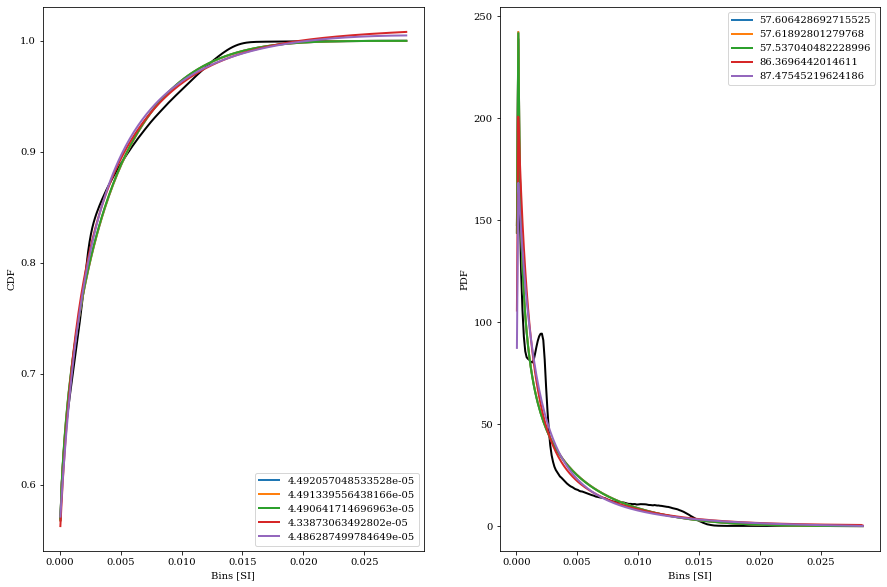

In [271]:
CDFplot(BIN['q'],CDF['q'],f['2_7'],f['2_8'],f['2_9'],f['4_9'],f['9_8'])

(<Figure size 1080x720 with 2 Axes>,
 array([<AxesSubplot:xlabel='Bins [SI]', ylabel='CDF'>,
        <AxesSubplot:xlabel='Bins [SI]', ylabel='PDF'>], dtype=object))

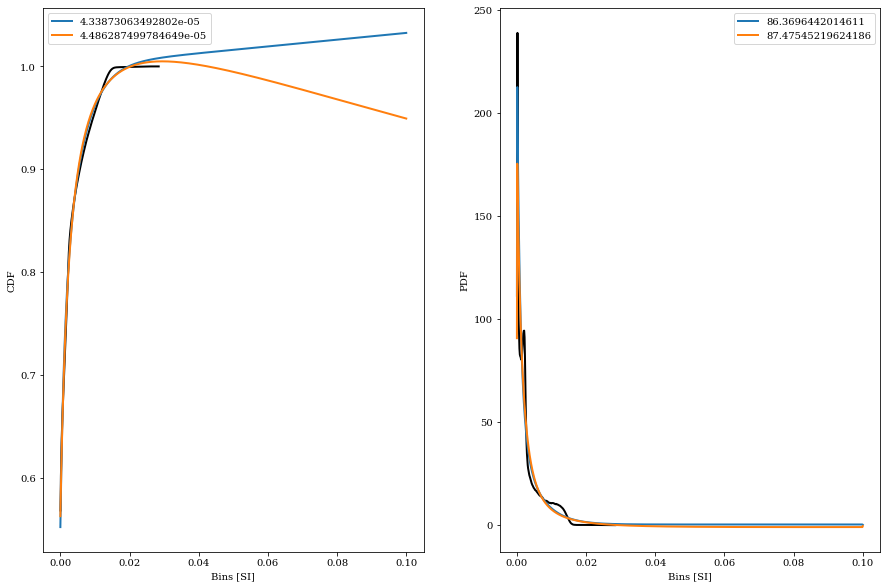

In [272]:
CDFplot_outside(BIN['q'],CDF['q'],f['4_9'],f['9_8'],
                bx=np.linspace(1e-5,0.1,1000))

Would pick blue

In [278]:
f0['4_9']

exp((0.32084858*x0*(sinh(201.598405211464*x0) + 0.28096297) - 0.16824582)/(sinh(201.598405211464*x0) + 0.28096297))

In [167]:
# Utilities

def relu(x):
    return x*(x>0)

def log10_abs(x):
    return np.log10(np.abs(x)+1e-8)

def cos(x):
    return np.cos(x)

def acosh_abs(x):
    return np.arccosh(np.abs(x)+1e-8+1)

def asinh(x):
    return np.arcsinh(x)

def cube(x):
    return x**3

def square(x):
    return x**2

def tanh(x):
    return np.tanh(x)

def tan(x):
    return np.tan(x)

def sin(x):
    return np.sin(x)

def sinh(x):
    return np.sinh(x)

def exp(x):
    return np.exp(x)

def atan(x):
    return np.arctan(x)

In [223]:
def CDFplot(bins,cdf,*argf):
        
    fig,ax = plt.subplots(1,2,figsize=(15,10))
    
    ax[0].plot(bins,cdf,color='k')
    for f in argf: ax[0].plot(bins,f(bins),label=str(mse(f(bins),cdf)))
    ax[0].set_xlabel('Bins [SI]'); ax[0].set_ylabel('CDF')
    ax[0].legend()
    
    pdf = cdf2pdf(bins,cdf)
    ax[1].plot(bins,pdf,color='k')
    for f in argf: ax[1].plot(bins,cdf2pdf(bins,f(bins)),label=str(mse(cdf2pdf(bins,f(bins)),pdf)))
    ax[1].set_xlabel('Bins [SI]'); ax[1].set_ylabel('PDF')
    ax[1].legend()
    
    return fig,ax

In [264]:
def CDFplot_outside(bins,cdf,*argf,bx=None):
        
    fig,ax = plt.subplots(1,2,figsize=(15,10))
    
    ax[0].plot(bins,cdf,color='k')
    if bx is None:
        bm = np.min(bins); bM = np.max(bins); br = bM-bm;
        bx = np.linspace(bm-br,bM+br,1000)
    for f in argf: ax[0].plot(bx,f(bx),label=str(mse(f(bins),cdf)))
    ax[0].set_xlabel('Bins [SI]'); ax[0].set_ylabel('CDF')
    ax[0].legend()
    
    pdf = cdf2pdf(bins,cdf)
    ax[1].plot(bins,pdf,color='k')
    for f in argf: ax[1].plot(bx,cdf2pdf(bx,f(bx)),label=str(mse(cdf2pdf(bins,f(bins)),pdf)))
    ax[1].set_xlabel('Bins [SI]'); ax[1].set_ylabel('PDF')
    ax[1].legend()
    
    return fig,ax

## Investigate approximate CDF for each key

In [128]:
def relu(x):
    return x*(x>0)

In [129]:
def log10_abs(x):
    return np.log10(np.abs(x)+1e-8)

In [232]:
def cos(x):
    return np.cos(x)

In [152]:
def acosh_abs(x):
    return np.arccosh(np.abs(x)+1e-8+1)

In [153]:
def asinh(x):
    return np.arcsinh(x)

In [154]:
def cube(x):
    return x**3

In [155]:
def square(x):
    return x**2

In [156]:
def tanh(x):
    return np.tanh(x)

In [220]:
def tan(x):
    return np.tan(x)

In [253]:
def sin(x):
    return np.sin(x)

In [234]:
def sinh(x):
    return np.sinh(x)

In [287]:
def exp(x):
    return np.exp(x)

In [288]:
def atan(x):
    return np.arctan(x)

In [73]:
def CDFplot(bins,cdf,f1,f2=None,f3=None,f4=None,f5=None,f6=None):
    fig,ax = plt.subplots(1,2,figsize=(15,10))
    
    ax[0].plot(bins,cdf,color='k')
    ax[0].plot(bins,f1(bins),label=str(mse(f1(bins),cdf)))
    if f2 is not None: ax[0].plot(bins,f2(bins),label=str(mse(f2(bins),cdf)))
    if f3 is not None: ax[0].plot(bins,f3(bins),label=str(mse(f3(bins),cdf)))
    if f4 is not None: ax[0].plot(bins,f4(bins),label=str(mse(f4(bins),cdf)))
    if f5 is not None: ax[0].plot(bins,f5(bins),label=str(mse(f5(bins),cdf)))
    if f6 is not None: ax[0].plot(bins,f6(bins),label=str(mse(f6(bins),cdf)))
    ax[0].set_xlabel('Bins [SI]'); ax[0].set_ylabel('CDF')
    ax[0].legend()
    
    pdf = cdf2pdf(bins,cdf)
    ax[1].plot(bins,pdf,color='k')
    ax[1].plot(bins,cdf2pdf(bins,f1(bins)),label=str(mse(cdf2pdf(bins,f1(bins)),pdf)))
    if f2 is not None: ax[1].plot(bins,cdf2pdf(bins,f2(bins)),label=str(mse(cdf2pdf(bins,f2(bins)),pdf)))
    if f3 is not None: ax[1].plot(bins,cdf2pdf(bins,f3(bins)),label=str(mse(cdf2pdf(bins,f3(bins)),pdf)))
    if f4 is not None: ax[1].plot(bins,cdf2pdf(bins,f4(bins)),label=str(mse(cdf2pdf(bins,f4(bins)),pdf)))
    if f5 is not None: ax[1].plot(bins,cdf2pdf(bins,f5(bins)),label=str(mse(cdf2pdf(bins,f5(bins)),pdf)))
    if f6 is not None: ax[1].plot(bins,cdf2pdf(bins,f6(bins)),label=str(mse(cdf2pdf(bins,f6(bins)),pdf)))
    ax[1].set_xlabel('Bins [SI]'); ax[1].set_ylabel('PDF')
    ax[1].legend()
    
    return fig,ax

### p

In [158]:
def Cp1(x):
    return ((x * 7.0862848e-6) + 0.19888523)

In [159]:
def Cp2(x):
    return ((x * 7.1e-6) + 0.19826105)

In [160]:
def atan(x):
    return np.arctan(x)

In [161]:
def Cp3(x):
    return atan((x * 1.0111259e-5) + 0.15006034) 

In [162]:
def Cp4(x):
    return atan(((x-1.6478578) * 1.0111259e-5) + 0.15006034)

In [163]:
def Cp5(x):
    return asinh(asinh((x * 1.0073041e-5) + 0.14486879))

(<Figure size 1080x720 with 2 Axes>,
 array([<AxesSubplot:xlabel='Bins [SI]', ylabel='CDF'>,
        <AxesSubplot:xlabel='Bins [SI]', ylabel='PDF'>], dtype=object))

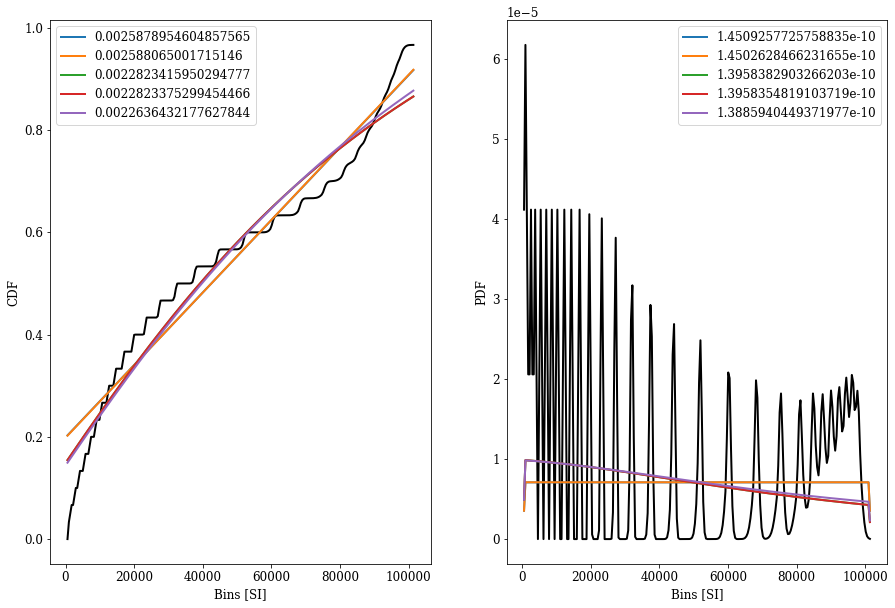

In [164]:
CDFplot(BIN['p'],CDF['p'],Cp1,Cp2,Cp3,Cp4,Cp5)

### q

In [165]:
SYMB['q']

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          0.6597048   
	1         0.065248                                   (x0 + 0.6454753)   
	2         0.351499                     ((x0 * 8.713648) + 0.53557384)   
	3         0.177640           ((acosh_abs(x0) * 1.466553) + 0.4266446)   
	4         0.015709     (tanh(acosh_abs(x0) * 1.5065193) + 0.42311612)   
	5   >>>>  1.161221         tanh(acosh_abs(acosh_abs(x0) * 2.2889612))   
	6         0.124367  tanh(tanh((acosh_abs(x0) * 8.244947) + 0.03879...   
	7         0.704534          erf(atan(tanh(acosh_abs(x0) * 8.828016)))   
	8         0.095923  erf(erf(acosh_abs((acosh_abs(x0) + -0.01067497...   
	9         0.053997  erf(erf(acosh_abs(((acosh_abs(x0) + -0.0106235...   
	10        0.085805  erf(erf(acosh_abs(tanh((acosh_abs(x0) + -0.010...   
	
	        loss  complexity  
	0   0.009086           1  
	1   0.007974           3  
	2   0.003948           5  
	3   0.002317           8  
	4   0.002210          11  
	5   0.000692          12  
	6   0.000540          14  
	7   0.000267          15  
	8   0.000220          17  
	9   0.000198          19  
	10  0.000181          20  
]

In [166]:
def Cq1(x):
    return ((acosh_abs(x) * 1.466553) + 0.4266446)

In [167]:
def Cq2(x):
    return (tanh(acosh_abs(x) * 1.5065193) + 0.42311612)

In [168]:
def Cq3(x):
    return tanh(acosh_abs(acosh_abs(x) * 2.2889612))

In [169]:
def Cq4(x0):
    return tanh(tanh((acosh_abs(x0) * 8.244947) + 0.038791586))

In [170]:
def Cq5(x0):
    return erf(atan(tanh(acosh_abs(x0) * 8.828016)))

(<Figure size 1080x720 with 2 Axes>,
 array([<AxesSubplot:xlabel='Bins [SI]', ylabel='CDF'>,
        <AxesSubplot:xlabel='Bins [SI]', ylabel='PDF'>], dtype=object))

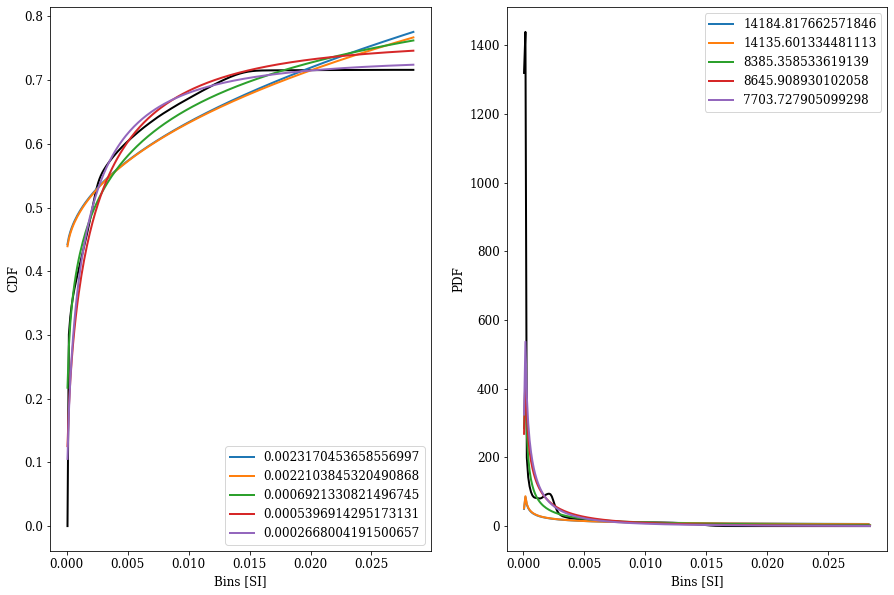

In [173]:
CDFplot(BIN['q'],CDF['q'],Cq1,Cq2,Cq3,Cq4,Cq5)

### dq/dp

In [181]:
SYMB['dq_dp_FD']

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                         0.48052174   
	1        0.000002                                  (x0 + 0.48053437)   
	2        0.000004                   (0.48045242 + (x0 / 0.33472282))   
	3  >>>>  4.016631                                    (relu(x0) / x0)   
	4        0.755452                    (relu(x0 + -6.0664007e-9) / x0)   
	5        0.096344  (relu((x0 + -6.0664007e-9) + -6.0664007e-9) / x0)   
	6        0.442418               cube((relu(x0) + -3.449002e-9) / x0)   
	7        0.000018        cube(((relu(x0) + -3.449002e-9) / x0) + x0)   
	8        0.058758     square(square((relu(x0) + -3.449002e-9) / x0))   
	9        0.062202  square(cube(relu(x0 + (-3.449002e-9 * 0.588521...   
	
	       loss  complexity  
	0  0.237857           1  
	1  0.237856           3  
	2  0.237854           5  
	3  0.004285           6  
	4  0.000946           8  
	5  0.000780          10  
	6  0.000501          11  
	7  0.000501          13  
	8  0.000472          14  
	9  0.000417          16  
]

In [183]:
def Cdq1(x):
    return(relu(x)/x)

In [185]:
def Cdq2(x0):
    return (relu(x0-6.0664007e-9) / x0)

In [186]:
def Cdq3(x0):
    return (relu((x0 + -6.0664007e-9) + -6.0664007e-9) / x0)

In [207]:
def Cdq3bis(x0):
    return (relu(x0 -2*6.0664007e-9) / x0)

In [187]:
def Cdq4(x0):
    return cube((relu(x0) + -3.449002e-9) / x0)

In [188]:
def Cdq5(x0):
    return cube(((relu(x0) + -3.449002e-9) / x0) + x0)

In [204]:
x = np.linspace(-2e-6,2e-6,1000)
y = Cdq3bis(x)

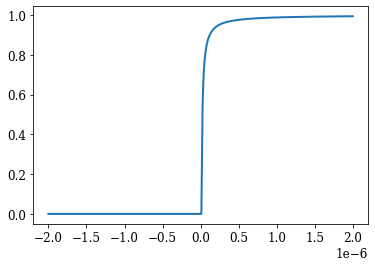

In [205]:
plt.plot(x,y)

(<Figure size 1080x720 with 2 Axes>,
 array([<AxesSubplot:xlabel='Bins [SI]', ylabel='CDF'>,
        <AxesSubplot:xlabel='Bins [SI]', ylabel='PDF'>], dtype=object))

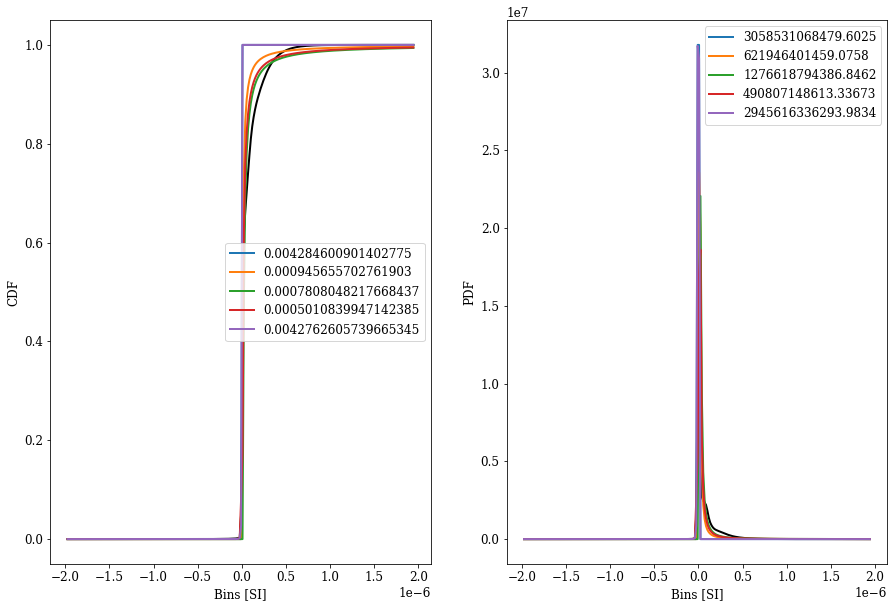

In [206]:
CDFplot(BIN['dq_dp_FD'],CDF['dq_dp_FD'],Cdq1,Cdq2,Cdq3bis,Cdq4,Cdq5bis)

### d2q_dp2

In [213]:
SYMB['d2q_dp2_FD']

PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                           0.415423   
	1  >>>>  1.078202e+00                                    (relu(x0) / x0)   
	2        1.565531e-02                      (relu(x0) / (x0 / 0.9910526))   
	3        2.865126e-07                      (erf(gamma(x0)) * 0.99105215)   
	4        3.952985e-03                abs((relu(x0) / x0) + -0.009228172)   
	5        8.382126e-03  ((relu(x0 / 0.9865989) / (x0 / 0.9724553)) + 0...   
	6        1.783539e-02            tanh(acosh_abs(square(gamma(x0)) / x0))   
	7        2.995314e-02  tanh(acosh_abs(square(gamma(x0) * 1.5830013) /...   
	8        9.706382e-03  tanh(acosh_abs((square(gamma(x0)) / (0.7322147...   
	9        4.493400e-01  tanh(acosh_abs((square(gamma(x0)) / abs(x0)) /...   
	
	       loss  complexity  
	0  0.237061           1  
	1  0.001080           6  
	2  0.001047           8  
	3  0.001047           9  
	4  0.001039          11  
	5  0.001030          12  
	6  0.000976          15  
	7  0.000920          17  
	8  0.000902          19  
	9  0.000576          20  
]

Decided to stay consistent: we should only transform base variables and not their derivatives nor integral with respect to p

In [214]:
SYMB.keys()

dict_keys(['p', 'q', 'dq_dp_FD', 'd2q_dp2_FD', 'Q_above', 'Q_below', 'T', 'dT_dp_FD', 'd2T_dp2_FD', 'T_above', 'T_below', 'RH', 'dRH_dp_FD', 'd2RH_dp2_FD', 'RH_above', 'RH_below', 'B', 'dB_dp_FD', 'd2B_dp2_FD', 'B_above', 'B_below', 'ps', 'S0', 'SHF', 'LHF', 'LHFns'])

### T

In [215]:
SYMB['T']

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          0.4660347   
	1        0.012709                    ((x0 / 4689.3906) + 0.41663957)   
	2  >>>>  1.361451                            (asinh(x0) + -5.654223)   
	3        0.063660              ((asinh(x0) + -5.654223) * 1.1360996)   
	4        1.290938                      tan(log10_abs(x0) * 2.845668)   
	5        0.040343                           cos(sinh(log10_abs(x0)))   
	6        0.658270    ((sinh(log10_abs(x0)) + -4.676634) * 0.8130205)   
	7        1.125591             relu(cosh(log10_abs(x0)) + -4.9190183)   
	8        0.163337  relu((sinh(log10_abs(x0)) + -4.776203) * 0.920...   
	9        0.189557  asinh(relu(sinh(log10_abs(x0)) + -4.8251963) /...   
	
	       loss  complexity  
	0  0.130465           1  
	1  0.123998           5  
	2  0.031779           6  
	3  0.027980           8  
	4  0.007695           9  
	5  0.007391          10  
	6  0.003826          11  
	7  0.001242          12  
	8  0.000896          14  
	9  0.000507          17  
]

In [228]:
SYMB['T'].equations_['equation'][8]

'relu((sinh(log10_abs(x0)) + -4.776203) * 0.92080903)'

In [217]:
def CT1(x0):
    return ((asinh(x0) + -5.654223) * 1.1360996)

In [218]:
def CT2(x0):
    return tan(log10_abs(x0) * 2.845668)

In [221]:
def CT3(x0):
    return cos(sinh(log10_abs(x0)))

In [229]:
def CT4(x0):
    return ((sinh(log10_abs(x0)) -4.676634) * 0.8130205)

In [230]:
def CT5(x0):
    return relu((sinh(log10_abs(x0)) -4.776203) * 0.92080903)

(<Figure size 1080x720 with 2 Axes>,
 array([<AxesSubplot:xlabel='Bins [SI]', ylabel='CDF'>,
        <AxesSubplot:xlabel='Bins [SI]', ylabel='PDF'>], dtype=object))

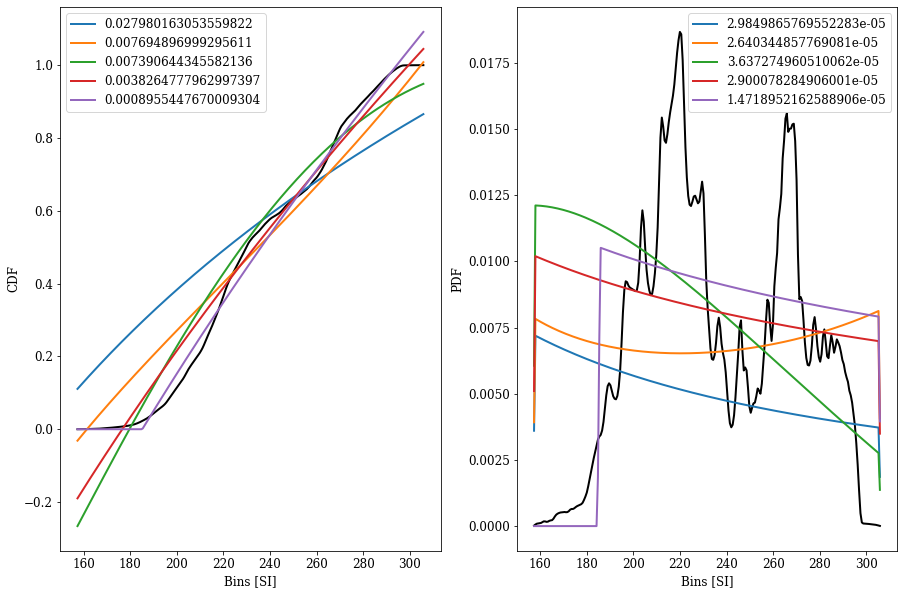

In [235]:
CDFplot(BIN['T'],CDF['T'],CT1,CT2,CT3,CT4,CT5)

### RH

In [239]:
SYMB['RH']

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         0.64414155   
	1         0.703681                                     (x0 / 1.46161)   
	2   >>>>  1.131399                                           tanh(x0)   
	3         0.088927                             tanh(x0 + 0.049660645)   
	4         0.151927                 cos((x0 * 0.7456167) + -1.4494222)   
	5         0.112183          cos(((x0 / 1.5445241) * x0) + -1.3076216)   
	6         0.091274                    cos(tanh(x0 * x0) + -1.3718212)   
	7         0.129941                  cos(square(sin(x0)) + -1.3400971)   
	8         0.233655      cos(sin((x0 * x0) * 0.73096704) + -1.3233962)   
	9         0.006712    cos(erf(x0 * tan(x0 * 0.6385504)) + -1.3339821)   
	10        0.151043  cos((tan(erf(square(x0))) * 0.60813665) + -1.3...   
	11        0.025643  cos(erf((cube(atan(x0)) + 0.29626366) * x0) + ...   
	
	        loss  complexity  
	0   0.069363           1  
	1   0.016979           3  
	2   0.005477           4  
	3   0.004585           6  
	4   0.003383           8  
	5   0.002703          10  
	6   0.002468          11  
	7   0.002167          12  
	8   0.001715          13  
	9   0.001681          16  
	10  0.001446          17  
	11  0.001373          19  
]

In [247]:
def CRH1(x0):
    return tanh(x0 + 0.049660645)   

In [248]:
def CRH2(x0):
    return cos((x0 * 0.7456167) + -1.4494222)

In [249]:
def CRH3(x0):
    return cos(((x0 / 1.5445241) * x0) + -1.3076216)

In [255]:
def CRH3bis(x0):
    return cos((x0**2 / 1.5445241)-1.3076216)

In [256]:
def CRH4(x0):
    return cos(tanh(x0 * x0) + -1.3718212)

In [257]:
def CRH5(x0):
    return cos(square(sin(x0)) + -1.3400971)

(<Figure size 1080x720 with 2 Axes>,
 array([<AxesSubplot:xlabel='Bins [SI]', ylabel='CDF'>,
        <AxesSubplot:xlabel='Bins [SI]', ylabel='PDF'>], dtype=object))

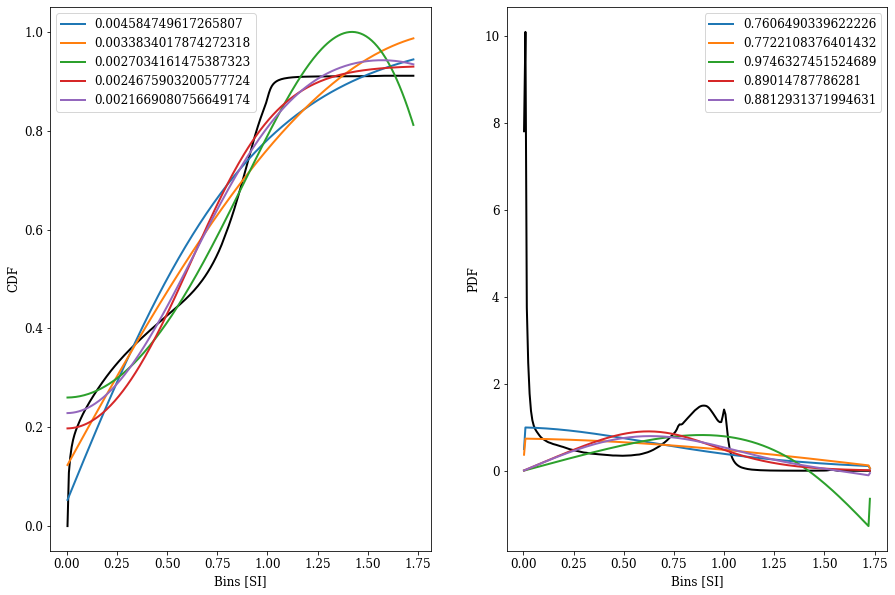

In [258]:
CDFplot(BIN['RH'],CDF['RH'],CRH1,CRH2,CRH3bis,CRH4,CRH5)

### B

In [259]:
SYMB['B']

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                         0.17385408   
	1         2.179764e-01                                            exp(x0)   
	2         1.069124e+00                  (-0.63707465 / (x0 + -1.0630977))   
	3         5.349891e-02                                       erf(exp(x0))   
	4   >>>>  1.518575e+00                exp((x0 + -0.7233477) * 0.42125773)   
	5         1.225986e-07  (exp((x0 + 0.42390448) * 0.42121932) * 0.61676...   
	6         2.684937e-01              tan(exp(x0 * 0.36915317) * 0.6298505)   
	7         4.815153e-01                      atan(exp(x0 / acosh_abs(x0)))   
	8         3.076130e-01     (atan(exp(x0 / acosh_abs(x0))) + -0.021364452)   
	9         3.397190e-01    tanh(exp((x0 + erf(1.2587 / x0)) * 0.41597065))   
	10        8.054806e-02  tanh(exp((x0 + tanh((1.7441895 / x0) + 0.41597...   
	11        6.829170e-02  sin(asinh(exp((x0 + erf(1.2852992 / x0)) * 0.4...   
	
	        loss  complexity  
	0   0.058042           1  
	1   0.030182           4  
	2   0.010362           5  
	3   0.009310           7  
	4   0.002039           8  
	5   0.002039          10  
	6   0.001559          11  
	7   0.000963          12  
	8   0.000521          14  
	9   0.000264          16  
	10  0.000225          18  
	11  0.000210          19  
]

In [278]:
SYMB['B'].equations_['equation'][11]

'sin(asinh(exp((x0 + erf(1.2852992 / x0)) * 0.41572052)))'

In [281]:
def CB1(x0):
    return (exp((x0 + 0.42390448) * 0.42121932) * 0.61676085)

In [282]:
def CB2(x0):
    return tan(exp(x0 * 0.36915317) * 0.6298505)

In [283]:
def CB3(x0):
    return (atan(exp(x0 / acosh_abs(x0))) + -0.021364452)

In [284]:
def CB4(x0):
    return tanh(exp((x0 + erf(1.2587 / x0)) * 0.41597065))

In [285]:
def CB5(x0):
    return sin(asinh(exp((x0 + erf(1.2852992 / x0)) * 0.41572052)))

In [302]:
x = np.linspace(-20,5,1000)

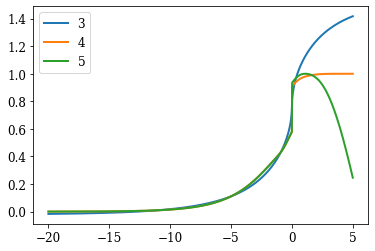

In [304]:
plt.plot(x,CB3(x),label='3')
plt.plot(x,CB4(x),label='4')
plt.plot(x,CB5(x),label='5')
plt.legend()

(<Figure size 1080x720 with 2 Axes>,
 array([<AxesSubplot:xlabel='Bins [SI]', ylabel='CDF'>,
        <AxesSubplot:xlabel='Bins [SI]', ylabel='PDF'>], dtype=object))

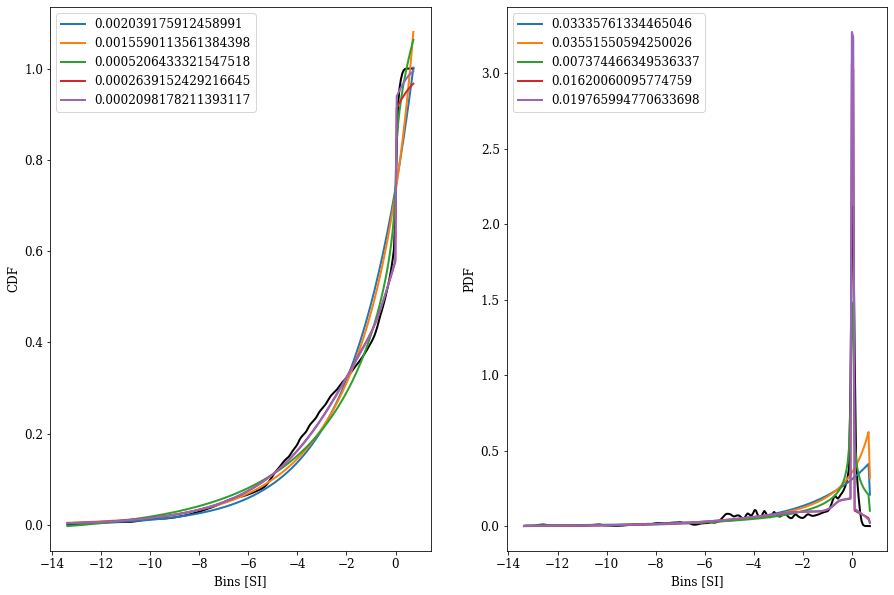

In [289]:
CDFplot(BIN['B'],CDF['B'],CB1,CB2,CB3,CB4,CB5)

### S0

In [295]:
SYMB['S0']

PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                         0.52389455   
	1        1.707798e-01                                (x0 * 0.0006513835)   
	2  >>>>  1.792580e+00                ((x0 * 0.00037715453) + 0.25788903)   
	3        9.489026e-08  (((x0 + 0.47315547) * 0.00037715456) + 0.2577103)   
	4        5.805845e-01               erf((x0 * 0.0004380256) + 0.2125754)   
	5        2.773172e-03  erf(((x0 + -1.4669467) * 0.0004380256) + 0.212...   
	6        3.984452e-03          erf((x0 * 0.0004380256) + sin(0.2125754))   
	
	       loss  complexity  
	0  0.024063           1  
	1  0.017100           3  
	2  0.000474           5  
	3  0.000474           7  
	4  0.000265           8  
	5  0.000264          10  
	6  0.000263          11  
]

In [316]:
SYMB['S0'].equations_['equation'][5]

'erf(((x0 + -1.4669467) * 0.0004380256) + 0.2125754)'

In [318]:
def CS1(x0):
    return ((x0 * 0.00037715456) + 0.25788875274309947)

In [319]:
def CS2(x0):
    return erf((x0 * 0.0004380256) + 0.2125754)

In [320]:
def CS3(x0):
    return erf(((x0 + -1.4669467) * 0.0004380256) + 0.2125754)

In [321]:
def CS3bis(x0):
    return erf(x0* 0.0004380256 + 0.21193283979156446)

In [322]:
def CS4(x0):
    return erf((x0 * 0.0004380256) + sin(0.2125754))

(<Figure size 1080x720 with 2 Axes>,
 array([<AxesSubplot:xlabel='Bins [SI]', ylabel='CDF'>,
        <AxesSubplot:xlabel='Bins [SI]', ylabel='PDF'>], dtype=object))

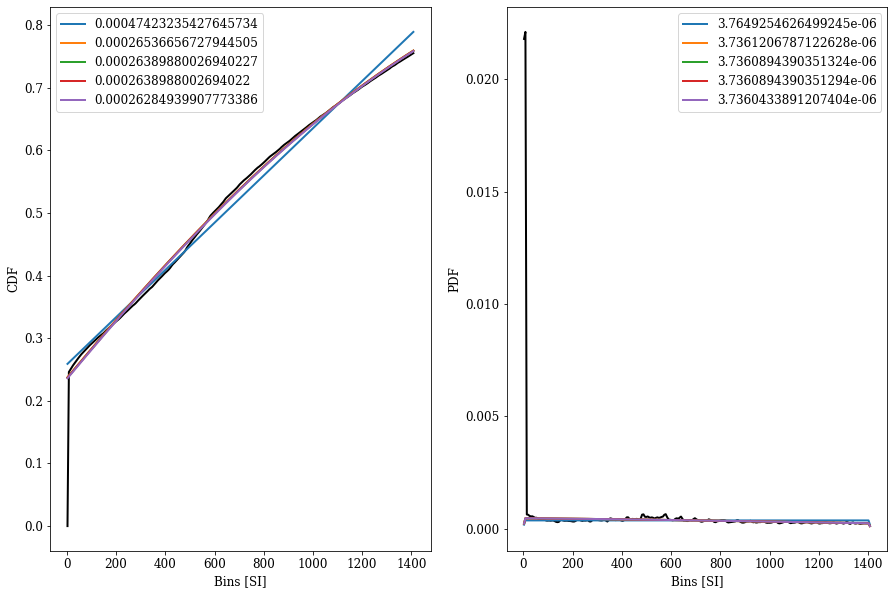

In [323]:
CDFplot(BIN['S0'],CDF['S0'],CS1,CS2,CS3,CS3bis,CS4)

### ps

In [305]:
SYMB['ps']

PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                         0.32389256   
	1        2.661791e-02                                (x0 * 3.4962316e-6)   
	2        8.950276e-07                  ((x0 + -3.623458) * 3.4962316e-6)   
	3  >>>>  1.627253e+00                             tan(x0 * 0.0001003494)   
	4        1.964622e-02               tan((x0 * 0.0001003494) * 1.0012354)   
	5        6.265687e-01                       relu(tan(x0 * 0.0001003494))   
	6        1.096630e+00        relu(sin((x0 / -0.10698126) * 3.813135e-5))   
	7        9.938513e-02                 erf(cube(tan(x0 * 0.00010227697)))   
	8        3.916341e-04           erf(relu(cube(tan(x0 * 0.00010227697))))   
	9        7.860003e-01  tanh(square(square(tan(x0 * 0.00010227697)) / ...   
	
	       loss  complexity  
	0  0.164973           1  
	1  0.156420           3  
	2  0.156420           5  
	3  0.030732           6  
	4  0.029547           8  
	5  0.015791           9  
	6  0.001762          11  
	7  0.001595          12  
	8  0.001593          15  
	9  0.000331          17  
]

In [326]:
def Cps1(x0):
    return tan(1e-4*x0)

In [327]:
def Cps2(x0):
    return relu(tan(x0 * 0.0001003494))

In [329]:
def Cps3(x0):
    return relu(sin(-0.00035643018225808897*x0))

In [330]:
def Cps4(x0):
    return erf(cube(tan(x0 * 0.00010227697)))

In [333]:
def Cps5(x0):
    return tanh(square(square(tan(x0 * 0.00010227697)) / 0.79570395))

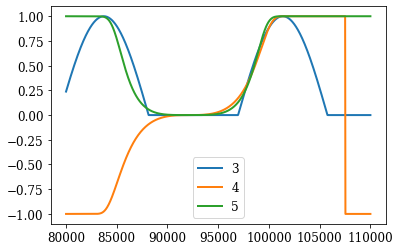

In [337]:
x = np.linspace(8e4,1.1e5,1000)
plt.plot(x,Cps3(x),label=3)
plt.plot(x,Cps4(x),label=4)
plt.plot(x,Cps5(x),label=5)
plt.legend()

(<Figure size 1080x720 with 2 Axes>,
 array([<AxesSubplot:xlabel='Bins [SI]', ylabel='CDF'>,
        <AxesSubplot:xlabel='Bins [SI]', ylabel='PDF'>], dtype=object))

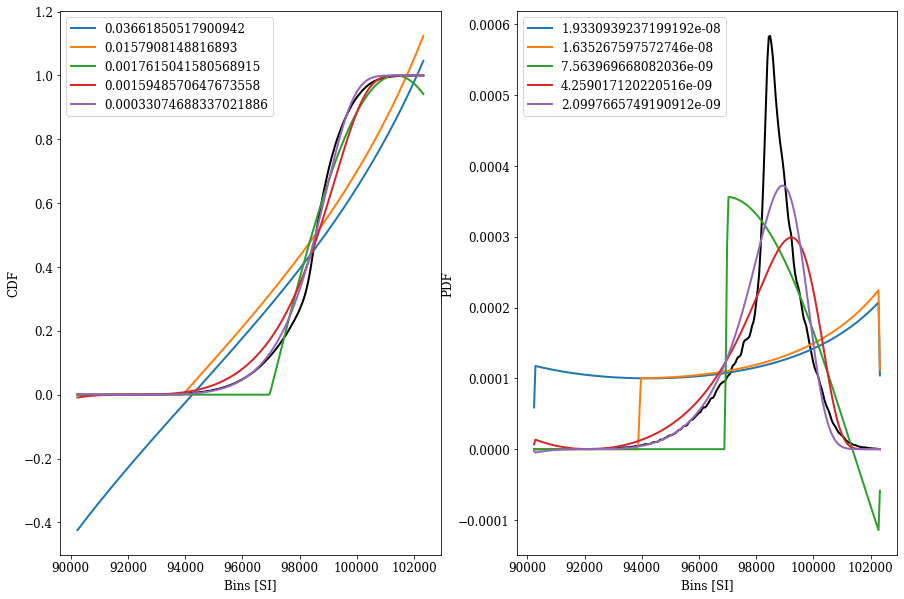

In [334]:
CDFplot(BIN['ps'],CDF['ps'],Cps1,Cps2,Cps3,Cps4,Cps5)

### SHF

In [306]:
SYMB['SHF']

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          0.7484917   
	1         0.031224                                 (x0 * 0.005530436)   
	2         0.737390                                    (relu(x0) / x0)   
	3         0.089714                                     tanh(relu(x0))   
	4   >>>>  2.069134                         relu(tanh(x0 / 17.040876))   
	5         0.341312         relu(tanh((x0 + 1.9651606) * 0.050640695))   
	6         0.018677                    relu(sin(atan(x0 / 14.301945)))   
	7         0.101489     erf(relu(x0) / (14.301945 + (x0 * 0.3797514)))   
	8         0.138220   erf(asinh(relu((1.1102548 + x0) * 0.049112942)))   
	9         0.073881  sin(atan((relu(x0) / 14.301945) + (-0.02191468...   
	10        0.132397       sin(relu(atan((erfc(x0) + x0) / 14.284215)))   
	11        0.013231  relu(sin(atan(((erfc(x0) + x0) + 0.07300863) /...   
	12        0.108434  relu(sin(atan((x0 + sinh(erfc(x0))) / 14.30194...   
	
	        loss  complexity  
	0   0.166387           1  
	1   0.156315           3  
	2   0.017111           6  
	3   0.015642           7  
	4   0.000250           9  
	5   0.000126          11  
	6   0.000124          12  
	7   0.000112          13  
	8   0.000097          14  
	9   0.000084          16  
	10  0.000074          17  
	11  0.000072          19  
	12  0.000064          20  
]

In [338]:
def CSHF1(x0):
    return relu(tanh(x0 / 17.040876)) 

In [339]:
def CSHF2(x0):
    return relu(tanh((x0 + 1.9651606) * 0.050640695))

In [340]:
def CSHF3(x0):
    return relu(sin(atan(x0 / 14.301945)))

In [341]:
def CSHF4(x0):
    return erf(asinh(relu((1.1102548 + x0) * 0.049112942)))

In [343]:
def CSHF5(x0):
    return sin(relu(atan((erfc(x0) + x0) / 14.284215))) 

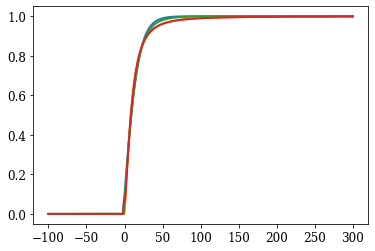

In [348]:
x = np.linspace(-100,300,1000)
plt.plot(x,CSHF2(x),label='2')
plt.plot(x,CSHF3(x),label='3')
plt.plot(x,CSHF4(x),label='4')
plt.plot(x,CSHF5(x),label='5')

(<Figure size 1080x720 with 2 Axes>,
 array([<AxesSubplot:xlabel='Bins [SI]', ylabel='CDF'>,
        <AxesSubplot:xlabel='Bins [SI]', ylabel='PDF'>], dtype=object))

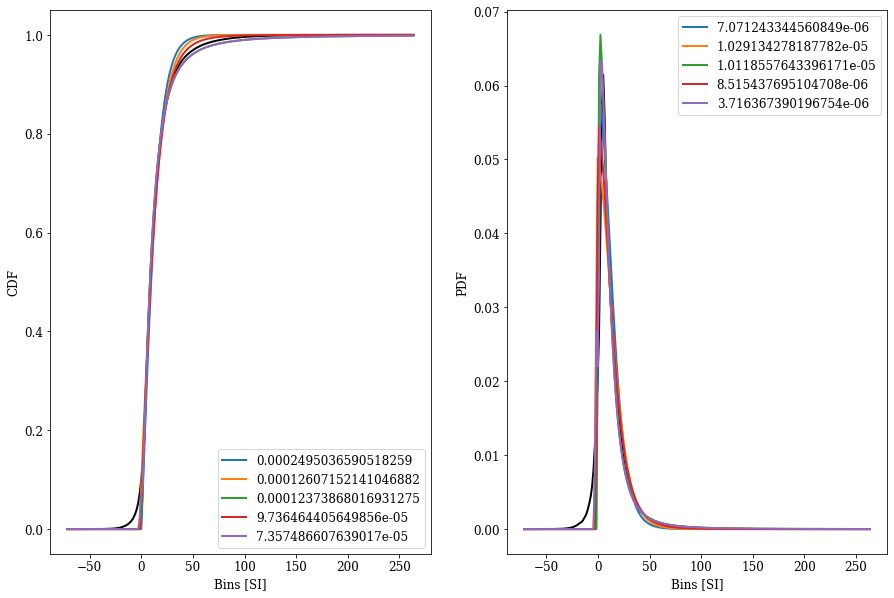

In [344]:
CDFplot(BIN['SHF'],CDF['SHF'],CSHF1,CSHF2,CSHF3,CSHF4,CSHF5)

### LHF

In [307]:
SYMB['LHF']

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          0.8261817   
	1         0.207811                 ((x0 * 0.0011043999) + 0.49342987)   
	2   >>>>  1.278886                              erf(x0 * 0.007366848)   
	3         0.859764              erf((x0 * 0.0060372413) + 0.21003938)   
	4         0.542992                       tanh(relu(x0 * 0.011640856))   
	5         0.420825         tanh(relu((x0 + 13.728397) * 0.009594211))   
	6         0.002220  tanh(relu(((x0 + -0.5272654) + 13.728397) * 0....   
	7         0.307301  relu(erf(asinh((x0 * 0.009258383) + 0.10951231...   
	8         0.011965  erf(asinh(relu((x0 * 0.009258383) + 0.11140866...   
	9         0.640888  erf(sinh(acosh_abs(relu(x0 * 0.00986395))) * 0...   
	10        0.107544  erf(sinh(acosh_abs(relu((x0 + -1.9279777) * 0....   
	
	        loss  complexity  
	0   0.097071           1  
	1   0.042275           5  
	2   0.011767           6  
	3   0.002108           8  
	4   0.001225           9  
	5   0.000528          11  
	6   0.000526          13  
	7   0.000387          14  
	8   0.000377          16  
	9   0.000199          17  
	10  0.000160          19  
]

In [349]:
def CLHF1(x0):
    return erf((x0 * 0.0060372413) + 0.21003938)

In [351]:
def CLHF2(x0):
    return tanh(relu((x0 + 13.2011316) * 0.009594211))

In [355]:
def CLHF3(x0):
    return erf(asinh(relu((x0 * 0.009258383) + 0.111408666)) / 1.019776)

In [359]:
def CLHF4(x0):
    return erf(sinh(acosh_abs(relu((x0 + -1.9279777) * 0.010095638))) * 0.4970752)

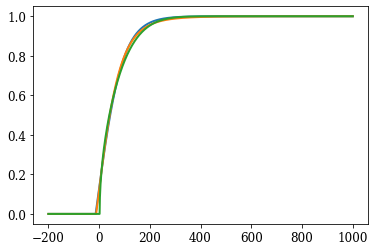

In [361]:
x = np.linspace(-200,1000,1000)
plt.plot(x,CLHF2(x))
plt.plot(x,CLHF3(x))
plt.plot(x,CLHF4(x))

(<Figure size 1080x720 with 2 Axes>,
 array([<AxesSubplot:xlabel='Bins [SI]', ylabel='CDF'>,
        <AxesSubplot:xlabel='Bins [SI]', ylabel='PDF'>], dtype=object))

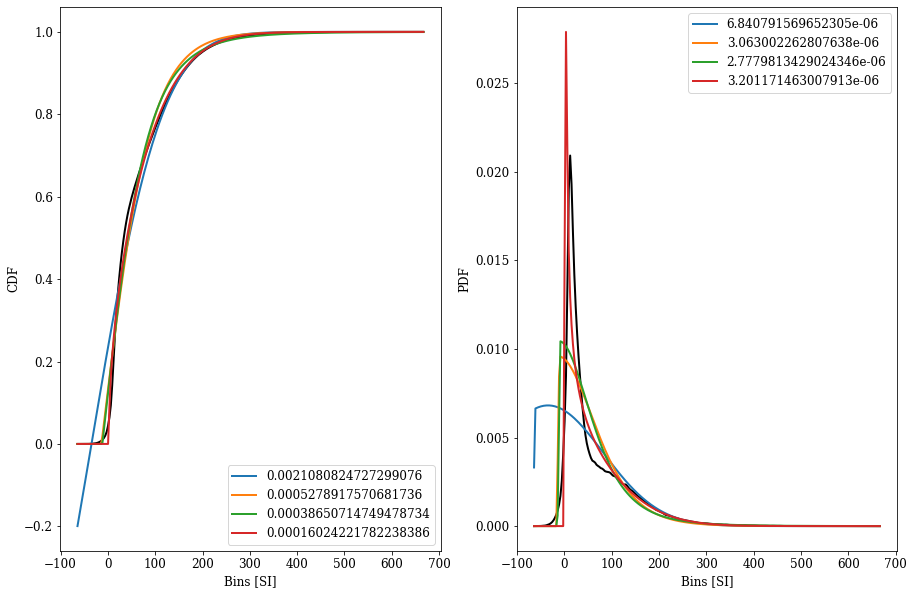

In [360]:
CDFplot(BIN['LHF'],CDF['LHF'],CLHF1,CLHF2,CLHF3,CLHF4)

### LHFns

In [308]:
SYMB['LHFns']

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          0.7735958   
	1         0.100366                                   (x0 + 0.7160109)   
	2         0.134567                   ((x0 / 0.36525574) + 0.69776046)   
	3         0.760302                                    (relu(x0) / x0)   
	4   >>>>  1.294228                       erfc(erfc(x0 / 0.019302044))   
	5         0.834987           erfc(erfc(x0 / 0.016462244) * 1.2864065)   
	6         0.128352  erfc(sinh(erfc((x0 / 0.016890993) + -0.0881646...   
	7         0.510435             erfc(abs(tan(erfc(x0 / 0.018755818))))   
	8         0.300580  square(erfc(erfc(asinh((x0 / 0.011873047) + 0....   
	9         0.189933  square(erfc(asinh(erfc(asinh(x0 / 0.011872489)...   
	10        0.044567  square(erfc(erfc(asinh((x0 / 0.011873049) + (0...   
	11        0.759271  square(erfc(asinh(erfc(asinh((x0 / 0.011873047...   
	
	        loss  complexity  
	0   0.145836           1  
	1   0.119313           3  
	2   0.091160           5  
	3   0.042620           6  
	4   0.000878           9  
	5   0.000165          11  
	6   0.000112          14  
	7   0.000067          15  
	8   0.000037          17  
	9   0.000031          18  
	10  0.000029          19  
	11  0.000014          20  
]

In [385]:
SYMB['LHFns'].equations_['equation'][11]

'square(erfc(asinh(erfc(asinh((x0 / 0.011873047) + 0.017934162)))))'

In [363]:
def CL1(x0):
    return erfc(erfc(x0 / 0.016462244) * 1.2864065)

In [368]:
def CL2(x0):
    return erfc(sinh(erfc((x0 / 0.016890993) + -0.08816465)))

In [386]:
def CL3(x0):
    return erfc(abs(tan(erfc(x0 / 0.018755818))))

In [387]:
def CL4(x0):
    return square(erfc(erfc(asinh((x0 / 0.011873049) + 0.023746098))))

In [388]:
def CL5(x0):
    return square(erfc(asinh(erfc(asinh((x0 / 0.011873047) + 0.017934162)))))

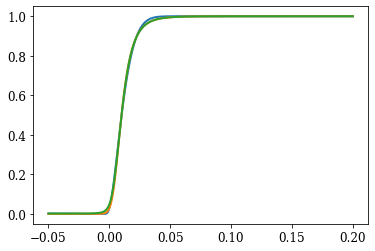

In [392]:
x = np.linspace(-0.05,0.2,1000)
plt.plot(x,CL3(x))
plt.plot(x,CL4(x))
plt.plot(x,CL5(x))

(<Figure size 1080x720 with 2 Axes>,
 array([<AxesSubplot:xlabel='Bins [SI]', ylabel='CDF'>,
        <AxesSubplot:xlabel='Bins [SI]', ylabel='PDF'>], dtype=object))

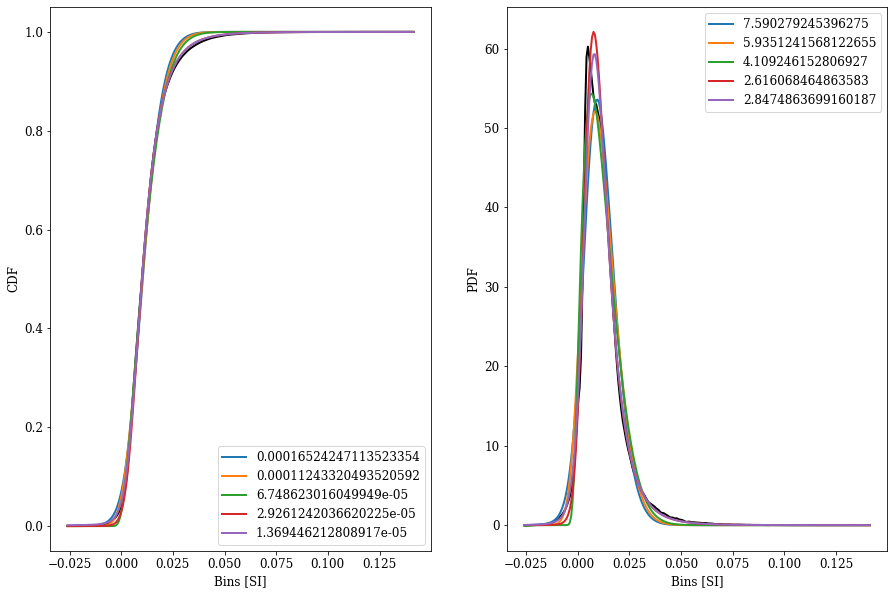

In [390]:
CDFplot(BIN['LHFns'],CDF['LHFns'],CL1,CL2,CL3,CL4,CL5)

### Compile all the functions here

In [393]:
def CDF_keys(x0,key):
    
    if key=='p': cdf = atan((x0 * 1e-5) + 0.15) # Retained third candidate
    elif key=='q': cdf = erf(atan(tanh(acosh_abs(x0) * 8.828))) # Retained last candidate
    elif key=='T': cdf = ((sinh(log10_abs(x0))-4.6766) * 0.813) # Retained last candidate that didn't ReLU neg T
    elif key=='RH': cdf = cos((x0*0.7456)-1.45) # Keeps monotonically increasing property of CDF
    elif key=='B': cdf = (atan(exp(x0 / acosh_abs(x0)))-0.0214) # Has the best CDF properties
    elif key=='S0': cdf = erf(x0* 0.000438 + 0.212) # Pretty "easy" CDF
    elif key=='ps': cdf = erf(cube(tan(x0 * 1e-4))) # Has better monotonicity properties, but not valid at high ps
    elif key=='SHF': cdf = relu(tanh((x0 + 1.965) * 0.05))
    elif key=='LHF': cdf = tanh(relu((x0 + 13.2) * 0.0096))
    elif key=='LHFns': cdf = square(erfc(erfc(asinh((x0 / 0.011873) + 0.023746))))
        
    return cdf